# Advanced Deep Learning Project - Part 1
## Group 8
### Yael Heger, Hila Baram, Ella Tamir

### Imports:

In [14]:
# Torch:
import torch
from torch import Tensor
from torch import tensor
from torch import from_numpy
from torch import FloatTensor
import torch.nn as nn
from torch.nn import Sigmoid
from torch.nn import Tanh
from torch.nn import Linear
from torch import zeros
from torch import cat
from torch import optim

# Numpy:
import numpy as np
from numpy import asarray
from numpy import zeros as np_zeros
from numpy import array

# Gensim:
import gensim
import gensim.downloader as api
from gensim.models import Word2Vec
from gensim.models.word2vec import Text8Corpus

# SkLearn:
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score, roc_curve, auc
from sklearn.metrics import accuracy_score

# Matplotlib:
import matplotlib.pyplot as plt
from matplotlib.ticker import MaxNLocator

# Others:
import pandas as pd
import os
import copy
import random
from tqdm import tqdm
import itertools
import re
import warnings
import pdb
import math

### Reading the data:

In [15]:
# Enter the location of the data localy.
#data_dir = 'C:\Users\yaelh\OneDrive\שולחן העבודה\נושאים מתקדמים בלמידה עמוקה\train'
#data_neg = 'C:/Users/yaelh/OneDrive/שולחן העבודה/נושאים מתקדמים בלמידה עמוקה/train/neg'
#data_pos = 'C:/Users/yaelh/OneDrive/שולחן העבודה/נושאים מתקדמים בלמידה עמוקה/train/pos'
# data_neg = 'D:/Users/ela86/Documents/University/Year_4/Semester_2/Advanced_Deep_Learning/Project/train_data/train/neg'
# data_pos = 'D:/Users/ela86/Documents/University/Year_4/Semester_2/Advanced_Deep_Learning/Project/train_data/train/pos'
# data_neg = 'C:/Users/Baram/Downloads/train/neg'
# data_pos = 'C:/Users/Baram/Downloads/train/pos'

In [16]:
def read_data_to_list(data_dir):
    # The function receives the path of the files.
    # The function returns a list containing the data.
    
    txt_files = []    # A list to save the opened review files.
    
    for (roots, dirs, files) in os.walk(data_dir): # Reading every file in every folder.     
        
        for obj in files:  
            file = open(roots + '/'+ obj, 'r', encoding = 'utf-8')
            cont = file.read()
            txt_files.append(cont)
            file.close()
    return txt_files

In [27]:
neg_rev = read_data_to_list(data_neg)
pos_rev = read_data_to_list(data_pos)

Defining the device - using cuda to run on GPU

In [18]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cuda')

### Preprocessing - Cleaning the data

Cleaning the data from non alphabetic characters & other non-words combinations.

In [28]:
def strip_special_chars(lst):
    sentence, clean_lst = "", []
    for sen in lst:
        cleanString = re.sub('<br>','', sen)
        cleanString = re.sub(r'[^A-Za-z0-9 ]+','', cleanString)
        cleanString = cleanString.lower()
        clean_lst.append(cleanString)
    return clean_lst

In [29]:
neg_clean = strip_special_chars(neg_rev)
pos_clean = strip_special_chars(pos_rev)

### Embedding:

Using the pre-trained gensim library models. Word2vec or GloVe ONLY.
available choices are:
- glove-twitter-100
- glove-twitter-200
- glove-twitter-25
- glove-twitter-50
- glove-wiki-gigaword-100
- glove-wiki-gigaword-200
- glove-wiki-gigaword-300
- glove-wiki-gigaword-50
- word2vec-google-news-300

default:
- for word2vec - word2vec.model, size = 100
- for GloVe - glove-wiki-gigaword, size = 300

In [19]:
def word2vec_embedding(model, data):
    # The function of the word2vec embedding.
    # The function receives the chosen model and the data to embedd.
    # The function returns the data embedded, in an array.
    rep_lis, representation = [], []
    for sen in data:        # Every review in the given data.
        for word in sen.split():  # Every word in the current review.
            if word not in model.wv.key_to_index:
                continue
            #else:
                #word_id = tensor(model.wv.key_to_index[word], device=device)  # ID of the word in the embedding
            vec = model.wv[word]
            representation.append(vec)
        representation = asarray(representation)
        rep_lis.append(representation)
        representation = []       # Initializing after every word.
    rep_lis = asarray(rep_lis)    # Converting to array.
    return rep_lis

In [20]:
def glove_embedding(glove_model, data):
    # The function of the GloVe embedding.
    # The function receives the chosen model and the data to embedd.
    # The function returns the data embedded, in an array.
    rep_lis, representation = [], []
    for sen in data:        # Every review in the given data.
        for word in sen.split():  # Every word in the current review.
            if word not in glove_model.key_to_index:
                continue
            #else:
                #word_id = tensor(glove_model.key_to_index[word], device = device)  # ID of the word in the embedding
            vec = glove_model[word]
            representation.append(vec)
        representation = asarray(representation)
        rep_lis.append(representation)
        representation = []      # Initializing after every word.
    rep_lis = asarray(rep_lis)   # Converting to array.
    return rep_lis

In [21]:
def Embedding(embedding_method, neg_data, pos_data, model_name = None,):
    # The function does the embedding according to the chosen method and model.
    # The function receives the choden methos, the negative and positive reviews and model name (optional)
    # The function returns the embedded data.
    model = None
    if embedding_method == "word2vec":
        if model_name == None:   # Use default model for word2vec.
            word2vec_model = Word2Vec.load("word2vec.model")
        else:                    # Use the selected model.
            #word2vec_model = gensim.models.keyedvectors.load_word2vec_format(model_name)
            word2vec_path = api.load(model_name, return_path=True)
            try:
                word2vec_model = gensim.models.keyedvectors.load_word2vec_format(word2vec_path)
            except:
                word2vec_model = gensim.models.keyedvectors.load_word2vec_format(word2vec_path, binary=True) 
        # Calling the embedding function.
        neg_embedded_data = word2vec_embedding(word2vec_model, neg_data)
        pos_embedded_data = word2vec_embedding(word2vec_model, pos_data)
        model = word2vec_model
        
        
    elif embedding_method == "glove":
        if model_name == None:  # Use default model for GloVe.
            glove_path = api.load('glove-wiki-gigaword-300', return_path=True)
            try:
                glove_model = gensim.models.keyedvectors.load_word2vec_format(glove_path)
            except:
                glove_model = gensim.models.keyedvectors.load_word2vec_format(glove_path, binary=True)
        else:                   # Use the selected model.
            glove_path = api.load(model_name, return_path=True)
            try:
                glove_model = gensim.models.keyedvectors.load_word2vec_format(glove_path)
            except:
                glove_model = gensim.models.keyedvectors.load_word2vec_format(glove_path, binary=True) 
        
        weights = FloatTensor(glove_model.vectors)
        embedding = nn.Embedding.from_pretrained(weights)
        embedding.requires_grad_(False)
        # Calling the embedding function.
        neg_embedded_data = glove_embedding(glove_model, neg_data)
        pos_embedded_data = glove_embedding(glove_model, pos_data)
        model = glove_model
    
    return model, neg_embedded_data, pos_embedded_data
        
            

#### Word2vec Embedding:

In [31]:
word2vec_model, negs_word2vec, pos_word2vec = Embedding("word2vec", neg_clean[:], pos_clean[:])

#### Glove Embedding:

In [12]:
glove_model, negs_glove, pos_glove = Embedding("glove", neg_clean[:], pos_clean[:])

C:\Users\Baram\anaconda3\lib\site-packages\numpy\core\_asarray.py:102: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return array(a, dtype, copy=False, order=order)


### Adding the Labels:

- label 1: positive reviews
- label 0: negativ reviews

In [32]:
pos_labels, neg_labels = [1]*len(pos_clean), [0]*len(neg_clean)
labels = pos_labels + neg_labels

#### Word2vec data

In [33]:
pos_word2vec_tensor = [from_numpy(x) for x in negs_word2vec]
neg_word2vec_tensor = [from_numpy(x) for x in negs_word2vec]

data_word2vec = pos_word2vec_tensor + neg_word2vec_tensor

##### Spliting the data into train and validation:

In [34]:
X_word2vec_train ,X_word2vec_val ,y_word2vec_train ,y_word2vec_val = train_test_split(data_word2vec, labels, test_size=0.25, random_state=42, shuffle = True)

#### Glove data

In [14]:
pos_glove_tensor = [from_numpy(x) for x in pos_glove]
neg_glove_tensor = [from_numpy(x) for x in negs_glove]

data_glove = pos_glove_tensor + neg_glove_tensor

##### Spliting the data into train and validation:

In [15]:
X_glove_train ,X_glove_val ,y_glove_train ,y_glove_val = train_test_split(data_glove, labels, test_size=0.25, random_state=42, shuffle = True)

## LSTM: 

### LSTM Cell

In [22]:
class LSTM_cell(torch.nn.Module):
    
    def __init__(self, input_length, hidden_length):
        super(LSTM_cell, self).__init__()
        self.input_length = input_length
        self.hidden_length = hidden_length
        
        # Defining the gates:
        
        # Forget gate components:
        self.forget_w1 = Linear(self.input_length, self.hidden_length, bias=True) 
        self.forget_u1 = Linear(self.hidden_length, self.hidden_length, bias=False)
        self.sigmoid_forget = Sigmoid()

        # Input gate components:
        self.input_w2 = Linear(self.input_length, self.hidden_length, bias=True)
        self.input_u2 = Linear(self.hidden_length, self.hidden_length, bias=False)
        self.sigmoid_gate = Sigmoid()

        # Cell memory components:
        self.memory_w3 = Linear(self.input_length, self.hidden_length, bias=True)
        self.memory_u3 = Linear(self.hidden_length, self.hidden_length, bias=False)
        self.activation_gate = Tanh()

        # Out gate components:
        self.out_w4 = Linear(self.input_length, self.hidden_length, bias=True)
        self.out_u4 = Linear(self.hidden_length, self.hidden_length, bias=False)
        self.sigmoid_hidden_out = Sigmoid()

        self.activation_final = Tanh()

    # The Gates functions:    
    def forget_gate(self, x, h):
        x = self.forget_w1(x)
        h = self.forget_u1(h)
        return self.sigmoid_forget(x + h)

    def input_gate(self, x, h):
        x_temp = self.input_w2(x)
        h_temp = self.input_u2(h)
        return self.sigmoid_gate(x_temp + h_temp)
    
    def cell_memory_gate(self, i, f, x, h, c_prev):
        x = self.memory_w3(x)
        h = self.memory_u3(h)

        # new information part that will be injected in the new context
        k = self.activation_gate(x + h)
        g = k * i
        
        # forget old context/cell info
        c = f * c_prev
        # learn new context/cell info
        c_next = g + c
        return c_next

    def out_gate(self, x, h):
        x = self.out_w4(x)
        h = self.out_u4(h)
        return self.sigmoid_hidden_out(x + h)

    def forward(self, x, inputs):  # inputs = c, h of the previous step and x=the new word (tuple)
        (h, c_prev) = inputs
        
        # 1. input gate
        i = self.input_gate(x, h)
        
        # 2. forget gate  
        f = self.forget_gate(x, h)

        # 3. updating the cell memory
        c_next = self.cell_memory_gate(i, f, x, h,c_prev)

        # 4. calculate the main output gate
        o = self.out_gate(x, h)

        # 5. produce next hidden output
        h_next = o * self.activation_final(c_next)

        return h_next, c_next


### LSTM Model: 

In [23]:
class LSTM(nn.Module):
    # The LSTM object receives the type of the embedding method - word2vec or GloVe.
    def __init__(self, embbeding_type):
        super(LSTM, self).__init__()
        if embbeding_type == "word2vec":
            self.vector_size = word2vec_model.vector_size
        else: # glove
            self.vector_size = glove_model.vector_size
        
        #Initializing the net:
        self.rnn = LSTM_cell(self.vector_size, self.vector_size)
        self.linear_words = Linear(self.vector_size, 1)
        self.sigmoid = Sigmoid()
        
        
        
    def forward(self, input):
        outputs, linear_out = None, Linear(input.size(0), 1, device=device)
        
        h_t, c_t = zeros(input.size(1), self.vector_size), zeros(input.size(1), self.vector_size)


        for i, input_t in enumerate(input.chunk(input.size(0), dim=0)):

            h_t, c_t = self.rnn.forward(input_t, (h_t, c_t))
            h_t = h_t[0]

            output = self.linear_words(h_t)
            
            if outputs is None:
                outputs = tensor(output, device=device)
            else:
                outputs = cat((outputs, tensor([output], device=device)), 0)

        fc = linear_out(outputs)  # Fully-conected layer
        review_result = self.sigmoid(fc)

        return review_result         
            
        

    def predict(self, x):
        if x >= 0.5: 
            result = 1  
        else:
            result = 0  
        return result   


# Train and Validate

In [24]:
def infer(model, data, labels, criterion, last = False):
    # The prediction on the validation set.
    # The function receives: LSTM model, validation data, validation labels, loss criterion and if it is the last epoch.
    # The function returns the validation set values: loss, AUC, fpr(false-positive rate), tpr(true-positive rate), accuracy.
    model.eval()
    running_loss, val_accuracies, predictions = 0, [], None
    
    for review in data:
        with torch.no_grad():
            review_pred = model.forward(review)
            pred = model.predict(review_pred[0].item())

            if predictions is None:
                predictions = tensor([pred], dtype = torch.float, device=device)
            else:
                predictions = cat((predictions, torch.tensor([pred], device=device)), 0)
            
            labels_tensor = tensor(labels, dtype = torch.float, device=device)
            n = predictions.shape[0]
            loss = criterion(predictions, labels_tensor[:n]).item()

        running_loss += loss
    fpr, tpr, thresholds = roc_curve(np.array(labels_tensor.cpu().detach().numpy()), np.array(predictions.cpu().detach().numpy()))
    val_accuracies.append(accuracy_score(labels_tensor.cpu().detach().numpy(), predictions.cpu().detach().numpy()))
    if last:
        return running_loss / len(data), auc(fpr, tpr), fpr, tpr, val_accuracies
    return running_loss / len(data)      ,    auc(fpr, tpr), val_accuracies

In [25]:
def training_loop(model, train_data, train_labels, val_data = None, val_labels = None, num_epochs = 50, 
                  criterion_func = nn.BCELoss, optimizer_func = optim.SGD, lr = 0.01, optim_count = 5):
    # The training, looping over all of the reviews in the train data.
    # Initialization:
    aucs, fpr_interp, tpr_interp, tr_accuracies, val_accuracies,aucs_val  = [], [], [], [], [], []
    criterion = criterion_func()
    optimizer = optimizer_func(model.parameters(), lr = lr)
    tr_loss, val_loss = [None] * num_epochs, [None] * num_epochs
    
    
    
    for epoch in tqdm(range(num_epochs)):
        running_tr_loss, optim_step_counter = 0, 0
        pred_array = np_zeros((len(train_data)))

        
        for i in range(len(train_data)):

            review_pred = model.forward(train_data[i])
            pred = model.predict(review_pred[0].item())
            pred_array[i] = pred
            

            predictions = tensor([pred], dtype = torch.float, device=device, requires_grad=True)

            optimizer.zero_grad()
            labels_tensor = tensor([train_labels[i]], dtype = torch.float, device=device, requires_grad=True)
            
            loss = criterion(predictions, labels_tensor)
            loss.backward()
            
            # optimizer:
            if optim_step_counter < optim_count:
                optim_step_counter += 1
            elif optim_step_counter == optim_count or epoch == num_epochs-2:
                optimizer.step()
                optim_step_counter = 0
                
            running_tr_loss += loss.item()
            


        tr_loss[epoch] = running_tr_loss / len(train_data)
        labels_tensor = tensor(train_labels, dtype = torch.float, device=device, requires_grad=True)
        tr_accuracies.append(accuracy_score(labels_tensor.cpu().detach().numpy(), pred_array))
        if criterion_func!=nn.MSELoss:
            fpr, tpr, thresholds = roc_curve(array(labels_tensor.cpu().detach().numpy()), pred_array)
            aucs.append(auc(fpr, tpr))

        # Validation set:    
        if val_data:
            if epoch == num_epochs-1:
                val_loss[epoch], auc_val, fpr, tpr, val_accuracy = infer(model, val_data, val_labels, criterion, last=True)
                tpr_interp = np.interp(np.linspace(0,1,100), fpr, tpr)
                fpr_interp = np.linspace(0,1,100)

            else:
                val_loss[epoch], auc_val, val_accuracy = infer(model, val_data, val_labels, criterion)
                aucs_val.append(auc_val)
            val_accuracies.append(val_accuracy)
        
            
            
    if not val_data:
        return tr_loss ,aucs
    return tr_loss, aucs, aucs_val, val_loss, fpr_interp, tpr_interp, tr_accuracies, val_accuracies





## Show the Results

In [26]:
def graph(tr_loss, tr_accuracies, val_accuracies, aucs, aucs_val, fpr_interp, tpr_interp):
    # Plotting the graphs:
    fig, axs = plt.subplots(2, 2, figsize = (12,12))
    
    # Loss per epoch:
    axs[0][0].xaxis.set_major_locator(MaxNLocator(integer=True))
    axs[0][0].plot(tr_loss,c='b',label="Train loss");
    axs[0][0].set_title('Loss (epoch) ')
    axs[0][0].set_ylabel('Loss')
    axs[0][0].set_xlabel('Epoch')
    axs[0][0].legend()
    
    # Accuracy per epoch:
    axs[0][1].xaxis.set_major_locator(MaxNLocator(integer=True))
    axs[0][1].plot(tr_accuracies,c='b',label="Train accuracy");
    axs[0][1].plot(val_accuracies,c='r',label="Test accuracy");
    axs[0][1].set_title('Accuracy (epoch) ')
    axs[0][1].set_ylabel('Accuracy')
    axs[0][1].set_xlabel('Epoch')
    axs[0][1].legend()
    
    # AUC per epoch:
    axs[1][1].xaxis.set_major_locator(MaxNLocator(integer=True))
    axs[1][1].plot(aucs,c='b',label="AUC-train") 
    axs[1][1].plot(aucs_val,c='r',label="AUC-test")
    axs[1][1].set_title('AUC (epoch) ')
    axs[1][1].set_ylabel('AUC')
    axs[1][1].set_xlabel('Epoch')
    axs[1][1].legend()
    
    # ROC per epoch:
    axs[1][0].plot(fpr_interp, tpr_interp, color = 'b',label="ROC")   #ROC
    axs[1][0].set_title('ROC ')
    axs[1][0].set_ylabel('tpr')
    axs[1][0].set_xlabel('fpr')
    axs[1][0].legend()
    plt.show()
    
    print(" AUC test is: ",str(aucs_val[-1]))

### Word2Vec 

In [35]:
model = LSTM("word2vec")

In [38]:
warnings.filterwarnings('ignore')
word2vec_tr_loss, word2vec_aucs, word2vec_aucs_val, word2vec_val_loss, word2vec_fpr_interp, word2vec_tpr_interp, word2vec_tr_accuracies, word2vec_val_accuracies = training_loop(model, X_word2vec_train, y_word2vec_train, X_word2vec_val, y_word2vec_val, num_epochs = 10, 
                  criterion_func = nn.MSELoss, optimizer_func = optim.SGD, lr = 0.05, optim_count = 15)


100%|█████████████████████████████████████████████████████████████████████████████| 10/10 [16:16:53<00:00, 5861.35s/it]


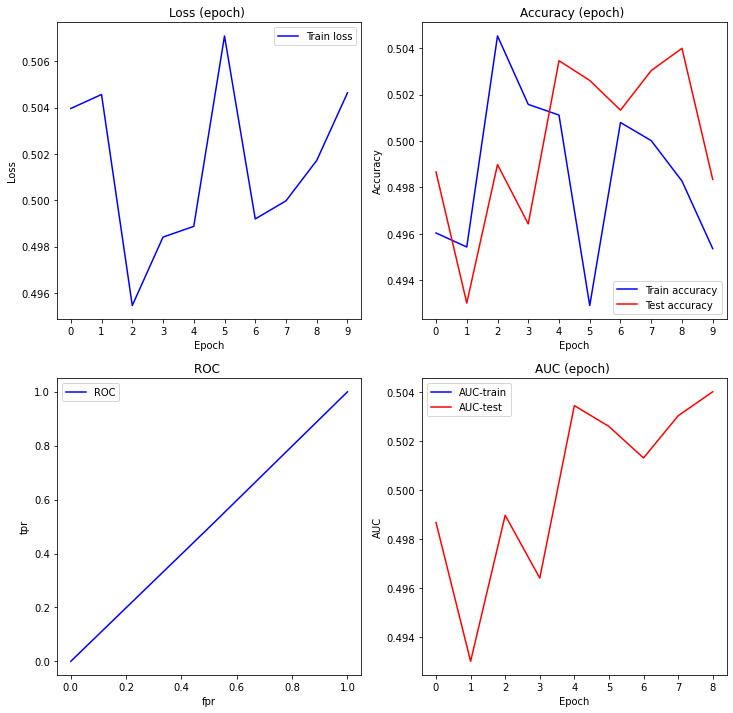

 AUC test is:  0.504008788450495


In [39]:
graph(word2vec_tr_loss, word2vec_tr_accuracies, word2vec_val_accuracies, word2vec_aucs, word2vec_aucs_val, word2vec_fpr_interp, word2vec_tpr_interp)

### Glove

In [21]:
model = LSTM("glove")

In [22]:
warnings.filterwarnings('ignore')
glove_tr_loss, glove_aucs, glove_aucs_val, glove_val_loss, glove_fpr_interp, glove_tpr_interp, glove_tr_accuracies, glove_val_accuracies = training_loop(model, X_glove_train, y_glove_train, X_glove_val ,y_glove_val, num_epochs=10, 
                  criterion_func = nn.MSELoss, optimizer_func = optim.SGD, lr = 0.05, optim_count = 15)


100%|█████████████████████████████████████████████████████████████████████████████| 10/10 [18:16:49<00:00, 6580.91s/it]


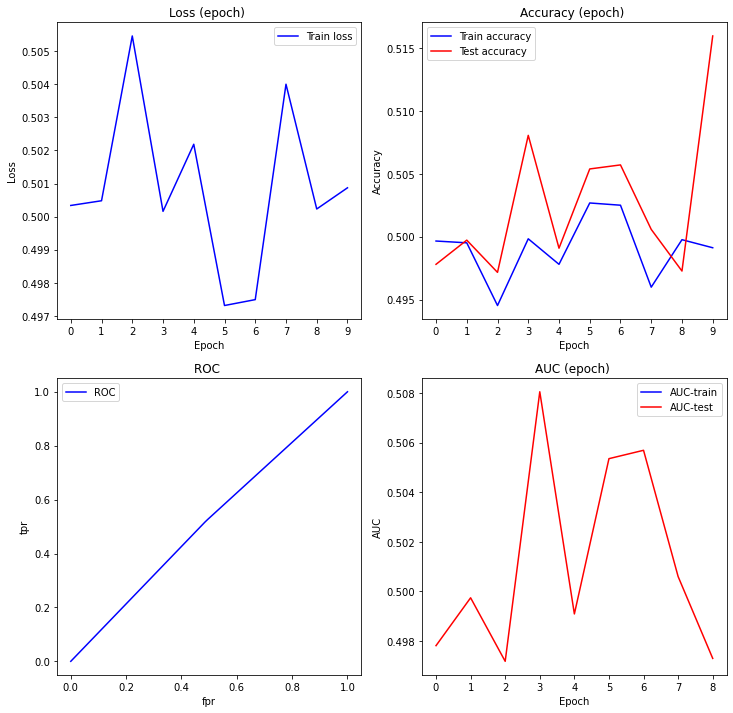

 AUC test is:  0.49729456956007767


In [23]:
graph(glove_tr_loss, glove_tr_accuracies, glove_val_accuracies, glove_aucs, glove_aucs_val, glove_fpr_interp, glove_tpr_interp)

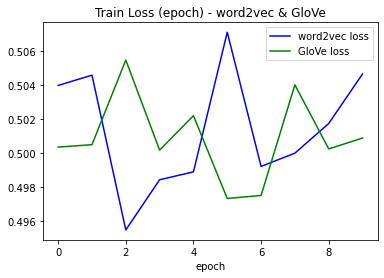

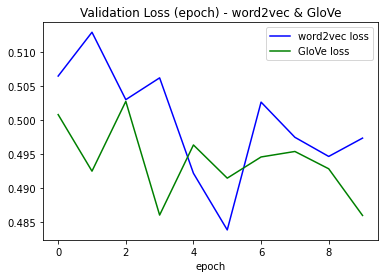

In [45]:
# Comparing the embedding methods:
fig, ax = plt.subplots()
ax.plot(word2vec_tr_loss, color = "b", label = "word2vec loss")
ax.plot(glove_tr_loss, color = "g", label = "GloVe loss")
ax.set_title('Train Loss (epoch) - word2vec & GloVe')
ax.set_xlabel('epoch')
ax.legend()
plt.show()

fig, ax = plt.subplots()
ax.plot(word2vec_val_loss, color = "b", label = "word2vec loss")
ax.plot(glove_val_loss, color = "g", label = "GloVe loss")
ax.set_title('Validation Loss (epoch) - word2vec & GloVe')
ax.set_xlabel('epoch')
ax.legend()


plt.show()


### Discussion: 

Throughout this assignment we learned how to implement RNN models, particulary the LSTM model and different embedding methods.
This work taught us a lot about the pytorch library, the struggles of implementing a therotical model in reality and how to work with different embedding methodes.
Due to the long time required to train the model on each epoch, and the lack of computational power, we were not able to train the model to our desired standard. However the model we implemented follows the theory learned in class and we believe that given more time to train we would have gotten better results.
Following that, comparing between the two embedding methods (word2vec and GloVe) is quite difficult but we can see that from one epoch to another the AUC for word2vec improved unlike the GloVe's AUC. When comparing the Loss values for the training for each embedding method - there was no siginificant difference.

To conclude, during this assignment we have learned a lot not only about the implementations of different subjects we learned during this course, but also about the struggles and limitations that are driven from computational power. As we move forward to the second part of this project, we will take all of this into mind.

# That's a wrap!

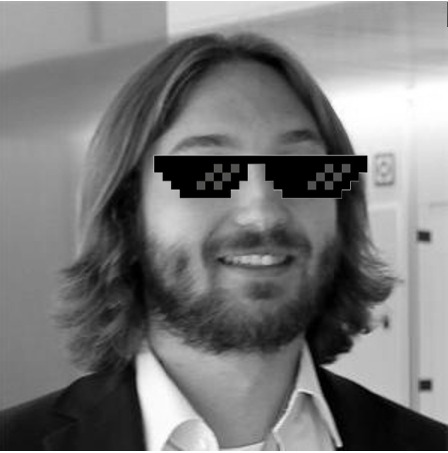

## Hyper- parameter tuning:

- Loss criterion = [BCE Loss, BCEWithLogitsLoss, MSELoss]

- lr = [0.5, 0.25, 0.2, 0.1, 0.05, 0.025, 0.02, 0.01]

- optimizer every [10, 15, 20, 50, 100] sentences

- optim func = [optim.ADAM, optim.Adagrad, optim.RMSprop, optim.SGD]


1) Changing the opitimizer functions: optim.ADAM, optim.Adagrad, optim.RMSprop, optim.SGD

In [ ]:
model = LSTM("word2vec")

In [ ]:
warnings.filterwarnings('ignore')
optimizers = [optim.ADAM, optim.Adagrad, optim.RMSprop, optim.SGD]
for optimizer in optimizers:
    print(" Optimizer is: ", optimizer)
    tr_loss, aucs, aucs_val, val_loss, fpr_interp, tpr_interp, tr_accuracies, val_accuracies = training_loop(model, X_word2vec_train[:1000], y_word2vec_train[:1000], X_word2vec_val[:250] ,y_word2vec_val[:250], num_epochs = 10, 
                  criterion_func = nn.BCELoss, optimizer_func = optimizer, lr = 0.1, optim_count = 10)

    graph(tr_loss, tr_accuracies, val_accuracies, aucs, aucs_val, fpr_interp, tpr_interp)

2) Changing the learning rate: 0.5, 0.25, 0.2, 0.1, 0.05, 0.025, 0.02, 0.01

In [ ]:
model = LSTM("word2vec")

In [ ]:
warnings.filterwarnings('ignore')
lrs = [0.5, 0.25, 0.2, 0.1, 0.05, 0.025, 0.02, 0.01]
for lr in lrs:
    print(" Learning rate is: ", lr)
    tr_loss, aucs, aucs_val, val_loss, fpr_interp, tpr_interp, tr_accuracies, val_accuracies = training_loop(model, X_word2vec_train[:1000], y_word2vec_train[:1000], X_word2vec_val[:250] ,y_word2vec_val[:250], num_epochs = 10, 
                  criterion_func = nn.BCELoss, optimizer_func = optim.SGD, lr = lr, optim_count = 10)

    graph(tr_loss, tr_accuracies, val_accuracies, aucs, aucs_val, fpr_interp, tpr_interp)

3) Changing the num of reviews to optim: 10, 15, 20, 50, 100

In [ ]:
model = LSTM("word2vec")

In [ ]:
warnings.filterwarnings('ignore')
to_optim_count = [10, 15, 20, 50, 100]
for count in to_optim_count:
    print(" Optim count is: ", count)
    tr_loss, aucs, aucs_val, val_loss, fpr_interp, tpr_interp, tr_accuracies, val_accuracies = training_loop(model, X_word2vec_train[:1000], y_word2vec_train[:1000], X_word2vec_val[:250] ,y_word2vec_val[:250], num_epochs = 10, 
                  criterion_func = nn.BCELoss, optimizer_func = optim.SGD, lr = 0.05, optim_count = count)

    graph(tr_loss, tr_accuracies, val_accuracies, aucs, aucs_val, fpr_interp, tpr_interp)

4) Changing the loss criterion: [BCE Loss, BCEWithLogitsLoss, MSELoss]

In [ ]:
model = LSTM("word2vec")

In [ ]:
warnings.filterwarnings('ignore')
loss_funcs = [nn.BCELoss, nn.BCEWithLogitsLoss, nn.MSELoss]
for lossF in loss_funcs:
    print(" Loss function is: ", lossF)
    tr_loss, aucs, aucs_val, val_loss, fpr_interp, tpr_interp, tr_accuracies, val_accuracies = training_loop(model, X_word2vec_train[:1000], y_word2vec_train[:1000], X_word2vec_val[:250] ,y_word2vec_val[:250], num_epochs = 10, 
                  criterion_func = lossF, optimizer_func = optim.SGD, lr = 0.05, optim_count = 15)

    graph(tr_loss, tr_accuracies, val_accuracies, aucs, aucs_val, fpr_interp, tpr_interp)